# Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error



# Loading and Visualizing the data

In [ ]:
# Load the data
df = pd.read_csv('/content/PJMW_hourly.csv')

# Set the 'Datetime' column as the index
df = df.set_index('Datetime')

# Convert the index to datetime format
df.index = pd.to_datetime(df.index)

#view the dataframe
df

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
...,...
2018-01-01 20:00:00,8401.0
2018-01-01 21:00:00,8373.0
2018-01-01 22:00:00,8238.0


In [ ]:
df.info() #info about the dataframe

In [ ]:
df.describe() #descriptive statistics

In [ ]:
# Create a color palette
color_pal = sns.color_palette()

# Set the plot style to 'fivethirtyeight'
plt.style.use('fivethirtyeight')


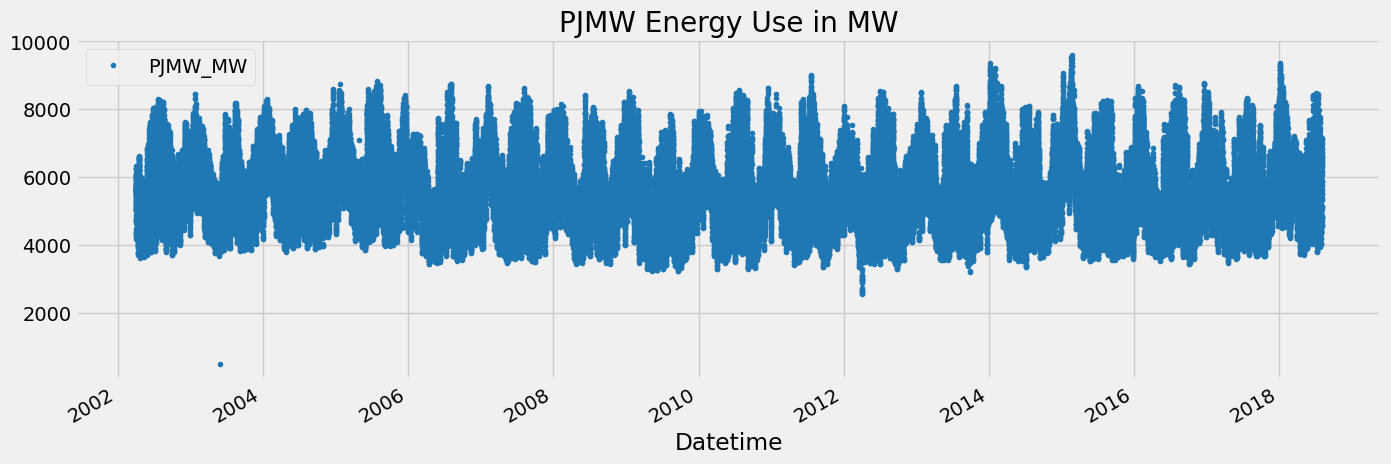

In [ ]:
# Plot the DataFrame
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJMW Energy Use in MW')

# Display the plot
plt.show()


# Outlier detection and removal

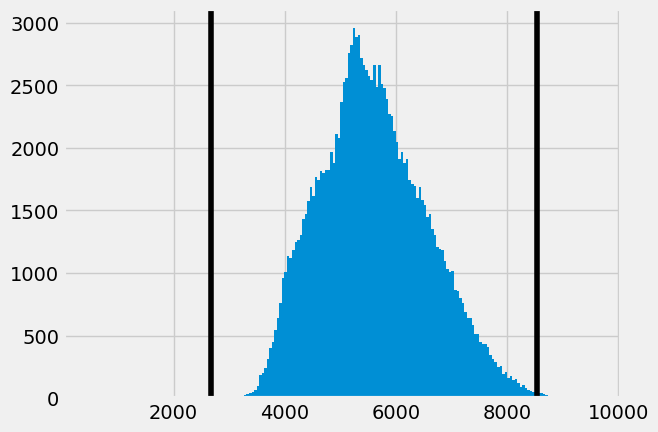

In [ ]:
#Outlier Detection
# Calculate the average
avg = df['PJMW_MW'].mean()

# Calculate the standard deviation
stdev = math.sqrt(((df['PJMW_MW'] - avg)**2).sum() / len(df))

# Plot the histogram
df['PJMW_MW'].hist(bins=200)

# Plot the lines for 3rd standard deviation on the histogram
plt.axvline(avg + stdev*3, color='black')
plt.axvline(avg - stdev*3, color='black')

# Display the plot
plt.show()


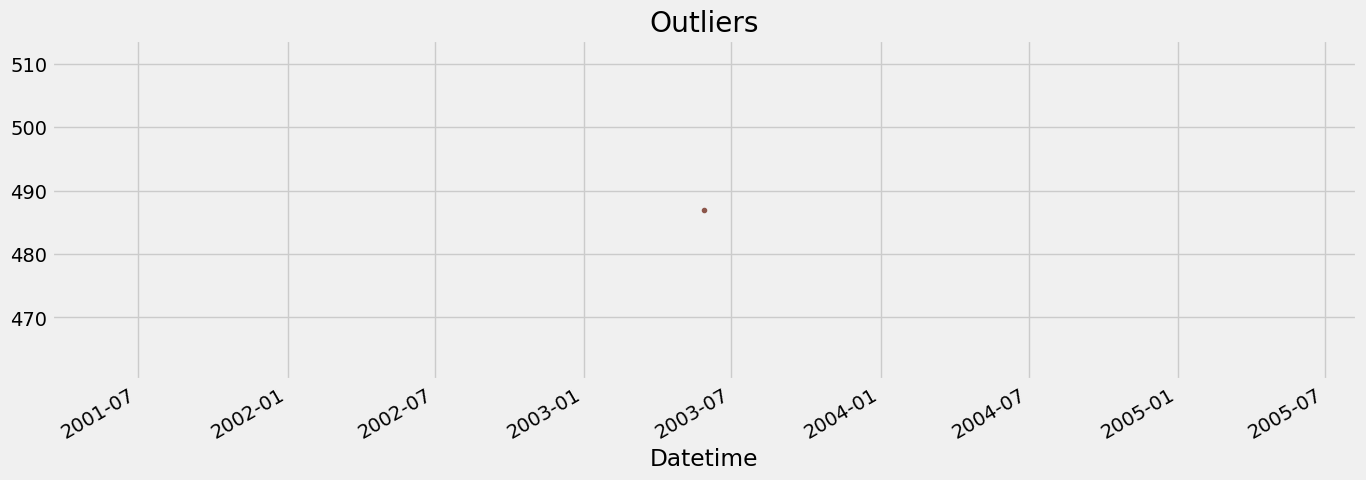

In [ ]:
# Filter the DataFrame for values less than 2000 and greater than 10000 in the 'PJMW_MW' column and plot them
df.loc[(df['PJMW_MW'] < 2000) | (df['PJMW_MW'] > 10000)]['PJMW_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers'
         )

# Display the plot
plt.show()


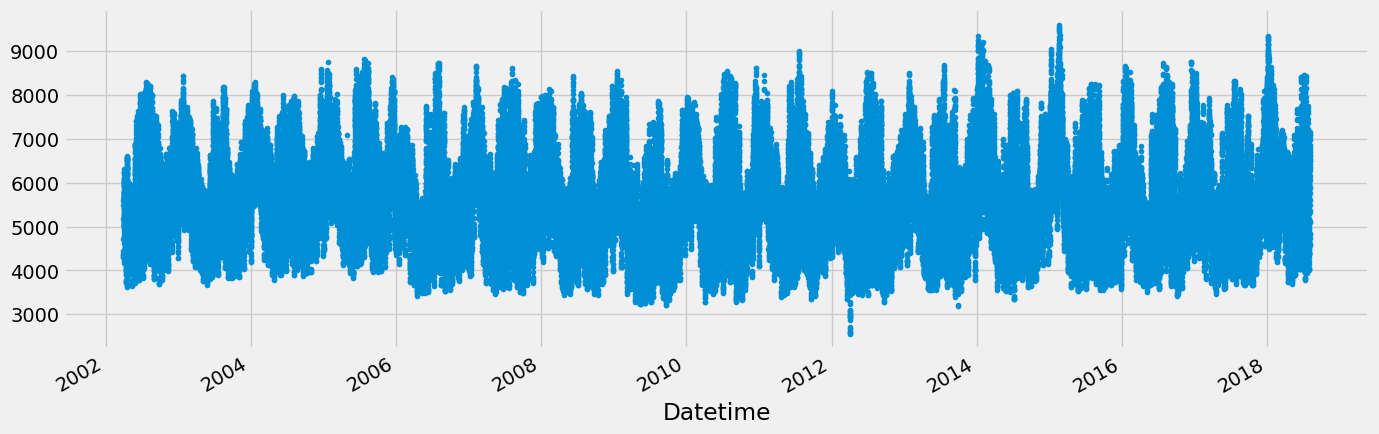

In [ ]:
# Remove outliers
df = df.loc[df['PJMW_MW'] > 2000].copy()

# Plot the filtered data
df['PJMW_MW'].plot(style='.', figsize=(15, 5))
plt.show()


# Preprocessing and data analysis

In [ ]:
#Create time series features based on time series index

def create_features(df):
  
    # Make a copy of the DataFrame
    df = df.copy()
    
    # Extract time-based features from the index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Return the modified DataFrame
    return df

# Load the data
df_1 = create_features(df)


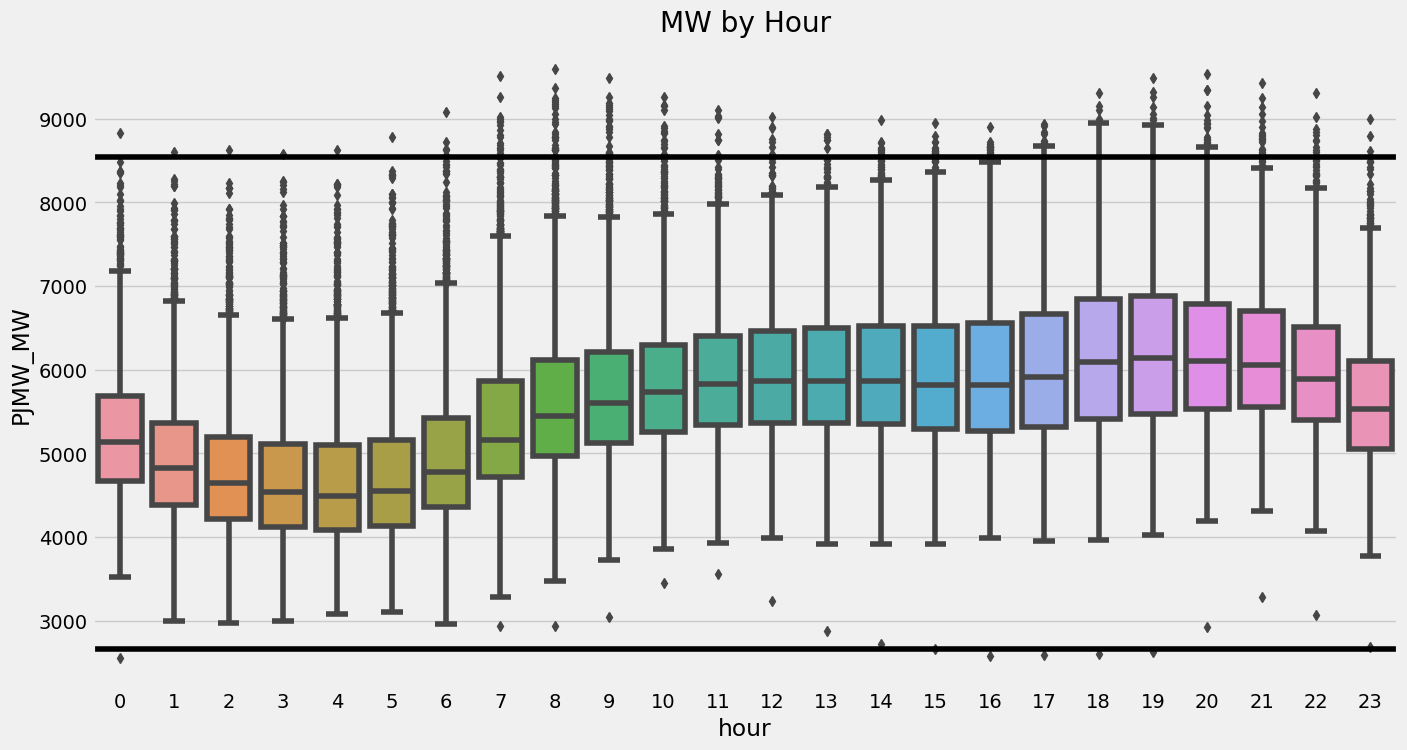

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Create a boxplot of 'PJME_MW' by 'hour'
graph = sns.boxplot(data=df_1, x='hour', y='PJMW_MW', ax=ax)

# Set the title of the plot
ax.set_title('MW by Hour')

# Add horizontal lines for the 3rd standard deviation
plt.axhline(avg + stdev*3, color='black')
plt.axhline(avg - stdev*3, color='black')


# Display the plot
plt.show()


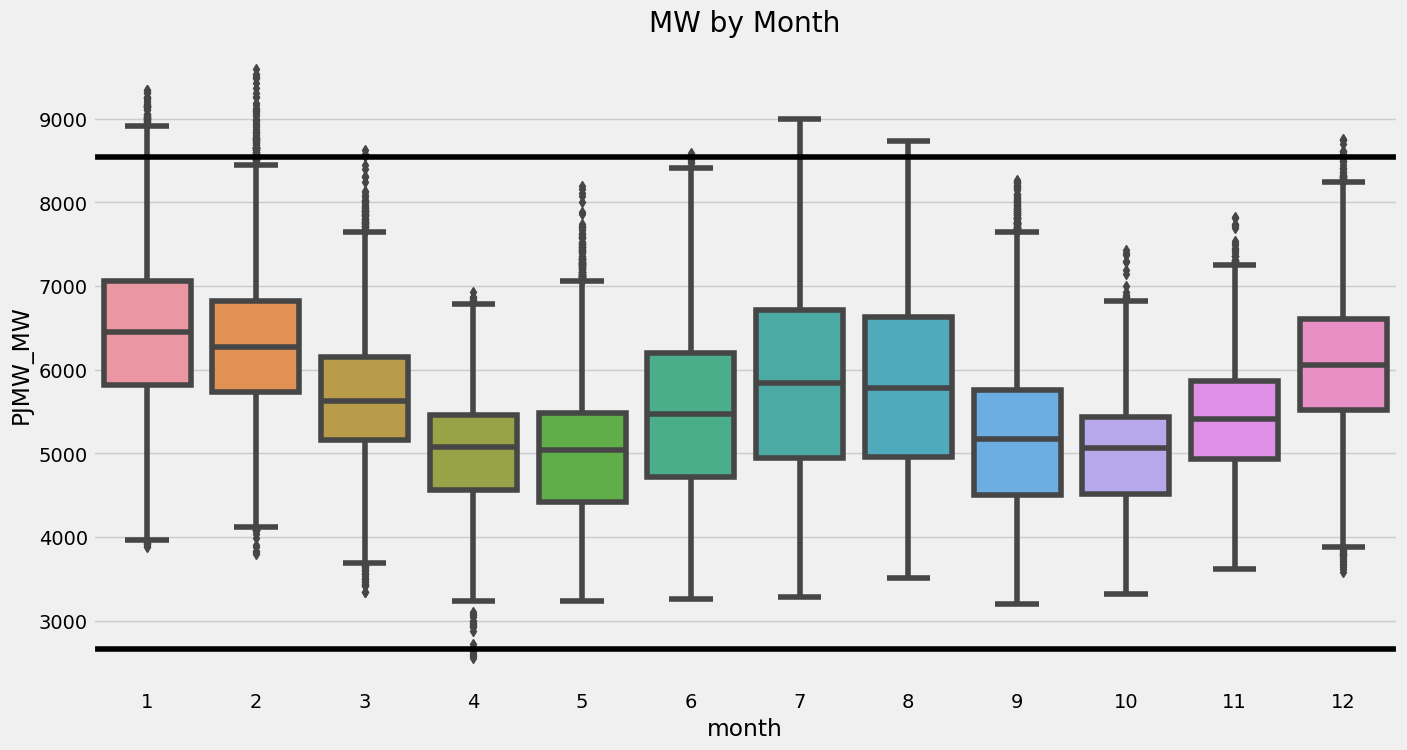

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Create a boxplot of 'PJME_MW' by 'month'
graph = sns.boxplot(data=df_1, x='month', y='PJMW_MW', ax=ax)

# Set the title of the plot
ax.set_title('MW by Month')

# Add horizontal lines for the 3rd standard deviation
plt.axhline(avg + stdev*3, color='black')
plt.axhline(avg - stdev*3, color='black')

# Display the plot
plt.show()


# Splitting data for cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object with 5 splits and a test size of 1 year (24*365 hours)
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1)

# Sort the DataFrame by the index (time series data needs to be sorted for TimeSeriesSplit)
df_2 = df_1.sort_index()


In [ ]:
tss

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=8760)

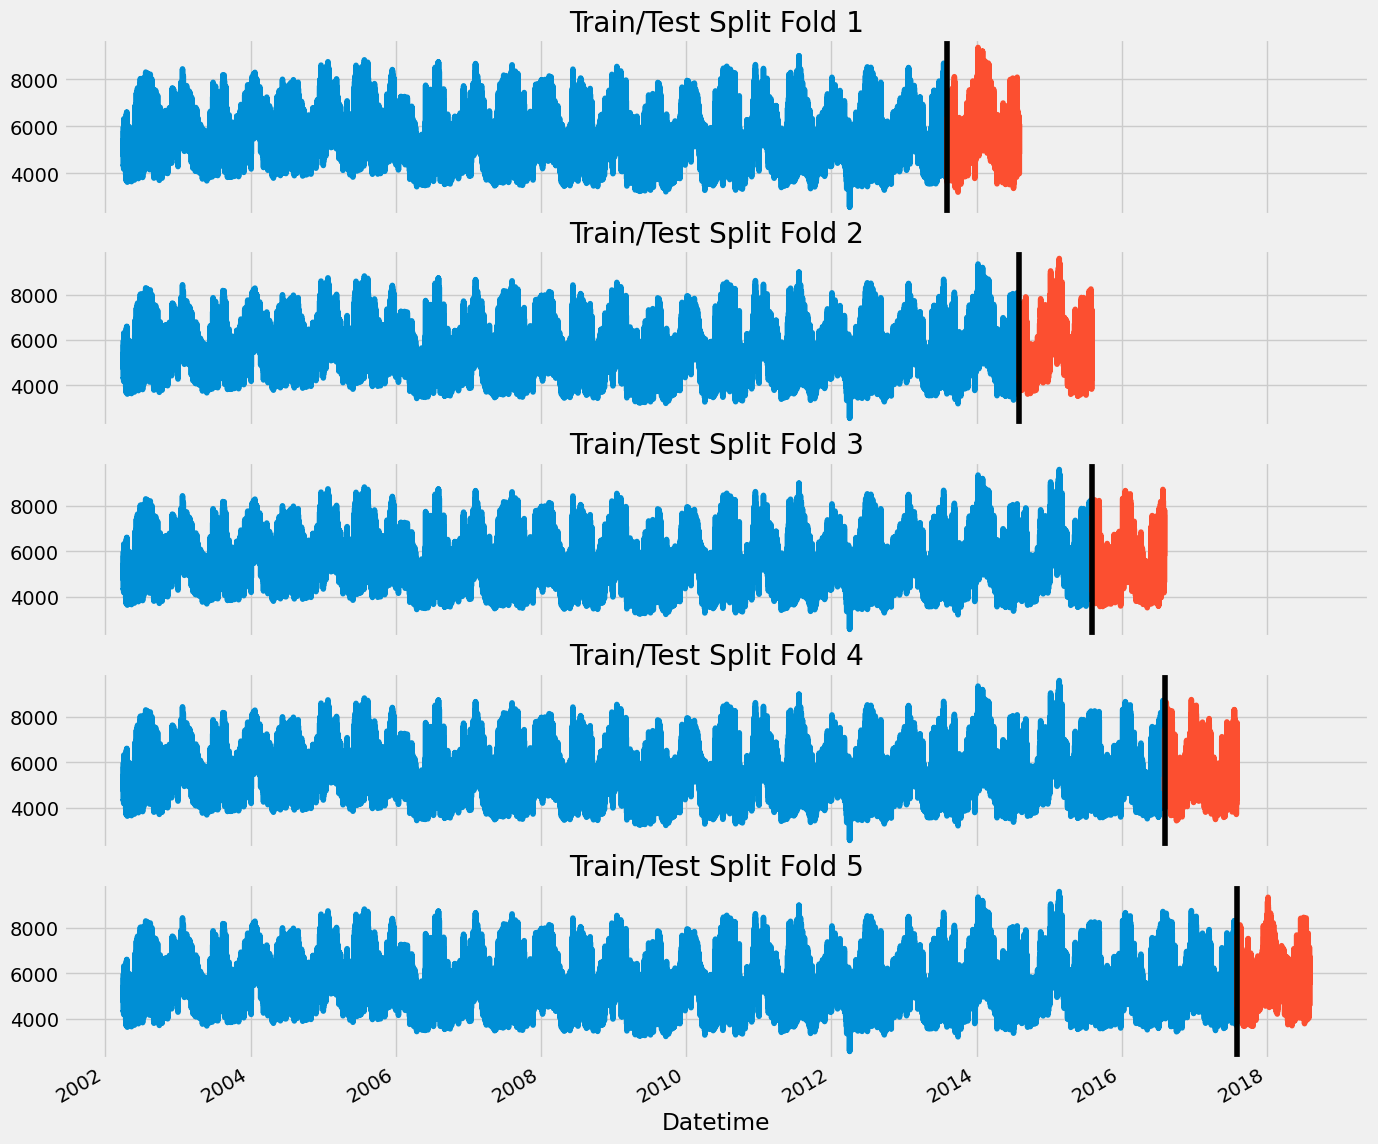

In [ ]:
# Create subplots with 5 rows and 1 column
fig, axes = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_2):
    # Split the data into train and test sets based on the indices
    train = df_2.iloc[train_idx]
    test = df_2.iloc[val_idx]
    
    # Plot the 'PJMW_MW' values for the training set on the corresponding subplot
    train['PJMW_MW'].plot(ax=axes[fold], label='Training Set', title=f'Train/Test Split Fold {fold+1}')
    
    # Plot the 'PJMW_MW' values for the test set on the corresponding subplot
    test['PJMW_MW'].plot(ax=axes[fold], label='Test Set')
    
    # Add a vertical line to indicate the start of the test set
    axes[fold].axvline(test.index.min(), color='black', ls='-')
    
    fold += 1


In [ ]:
df_2.describe()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
count,143205.000000,143205.000000,143205.000000,143205.000000,143205.000000,143205.000000,143205.000000,143205.000000,143205.0
mean,5602.410810,11.501700,2.998492,2.503579,6.502846,2009.918739,182.494599,15.725931,26.507412
std,979.052977,6.921746,1.999703,1.107745,3.419545,4.730325,104.555041,8.802483,14.939081
min,2553.000000,0.000000,0.000000,1.000000,1.000000,2002.000000,1.000000,1.000000,1.0
25%,4907.000000,6.000000,1.000000,2.000000,4.000000,2006.000000,94.000000,8.000000,14.0
50%,5530.000000,12.000000,3.000000,2.000000,6.000000,2010.000000,181.000000,16.000000,26.0
75%,6252.000000,18.000000,5.000000,3.000000,9.000000,2014.000000,272.000000,23.000000,39.0
max,9594.000000,23.000000,6.000000,4.000000,12.000000,2018.000000,366.000000,31.000000,53.0


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143205 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJMW_MW     143205 non-null  float64
 1   hour        143205 non-null  int64  
 2   dayofweek   143205 non-null  int64  
 3   quarter     143205 non-null  int64  
 4   month       143205 non-null  int64  
 5   year        143205 non-null  int64  
 6   dayofyear   143205 non-null  int64  
 7   dayofmonth  143205 non-null  int64  
 8   weekofyear  143205 non-null  UInt32 
dtypes: UInt32(1), float64(1), int64(7)
memory usage: 10.5 MB


In [ ]:
df_2['weekofyear'] = df_2['weekofyear'].astype(int)


# Fitting the model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds = []
scores = []
maes = []  # List to store MAE values
r2_scores = []  # List to store R2 scores

# Iterate over the time series splits
for train_idx, val_idx in tss.split(df):
    train = df_2.iloc[train_idx]
    test = df_2.iloc[val_idx]
    
    FEATURES = ['hour', 'dayofweek', 'weekofyear', 'month', 'year']
    TARGET = 'PJMW_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.03)
    
    # Fit the model on the training data
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    # Predict on the test data
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    # Calculate RMSE
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    
    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)


[0]	validation_0-rmse:5513.79543	validation_1-rmse:5576.44675
[100]	validation_0-rmse:626.13216	validation_1-rmse:787.92757
[200]	validation_0-rmse:504.32441	validation_1-rmse:666.19834
[300]	validation_0-rmse:478.62515	validation_1-rmse:648.56972
[400]	validation_0-rmse:462.43535	validation_1-rmse:644.08859
[420]	validation_0-rmse:460.25212	validation_1-rmse:643.28242
[0]	validation_0-rmse:5518.77162	validation_1-rmse:5652.04031
[100]	validation_0-rmse:637.53226	validation_1-rmse:767.04913
[200]	validation_0-rmse:516.45369	validation_1-rmse:611.08476
[300]	validation_0-rmse:490.92618	validation_1-rmse:592.22643
[400]	validation_0-rmse:475.13710	validation_1-rmse:581.47814
[500]	validation_0-rmse:462.26293	validation_1-rmse:573.34552
[600]	validation_0-rmse:455.00201	validation_1-rmse:568.97860
[684]	validation_0-rmse:448.80168	validation_1-rmse:569.05143
[0]	validation_0-rmse:5528.58217	validation_1-rmse:5357.08484
[100]	validation_0-rmse:641.96765	validation_1-rmse:649.02956
[174]	va

# Evaluation metrics for training set

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print('Average RMSE:', sum(scores)/len(scores))
print("Average MAE:", np.mean(maes))
print("Average R-Square:", np.mean(r2_scores))


Score across folds 636.1910
Fold scores:[643.03017137462, 567.0208103155027, 631.7950899909526, 653.3865824231185, 685.7221227248584]
Average RMSE: 636.1909553658104
Average MAE: 477.266002030046
Average R-Square: 0.6036849310891714


# Important Features

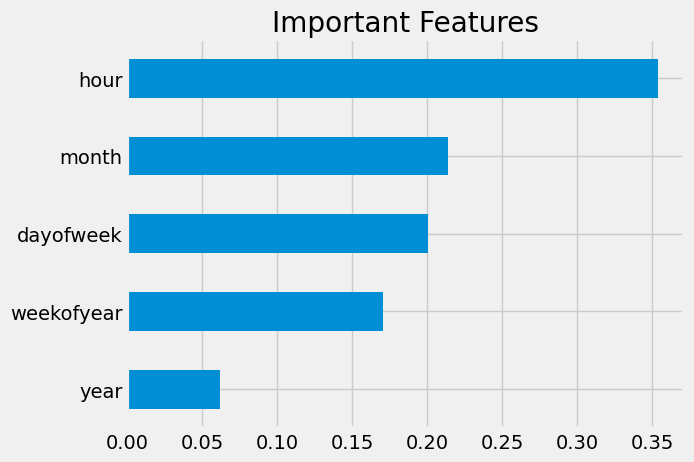

In [ ]:
Important_features = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

# Sort the features based on importance and plot them in a horizontal bar chart
Important_features.sort_values('importance').plot(kind='barh', title='Important Features',legend=False)
plt.show()


In [ ]:
Important_features

,importance
hour,0.353772
dayofweek,0.200324
weekofyear,0.170536
month,0.213738
year,0.061630


# Comparing true data and predictions

<ipython-input-18-c281f1bb9ee0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


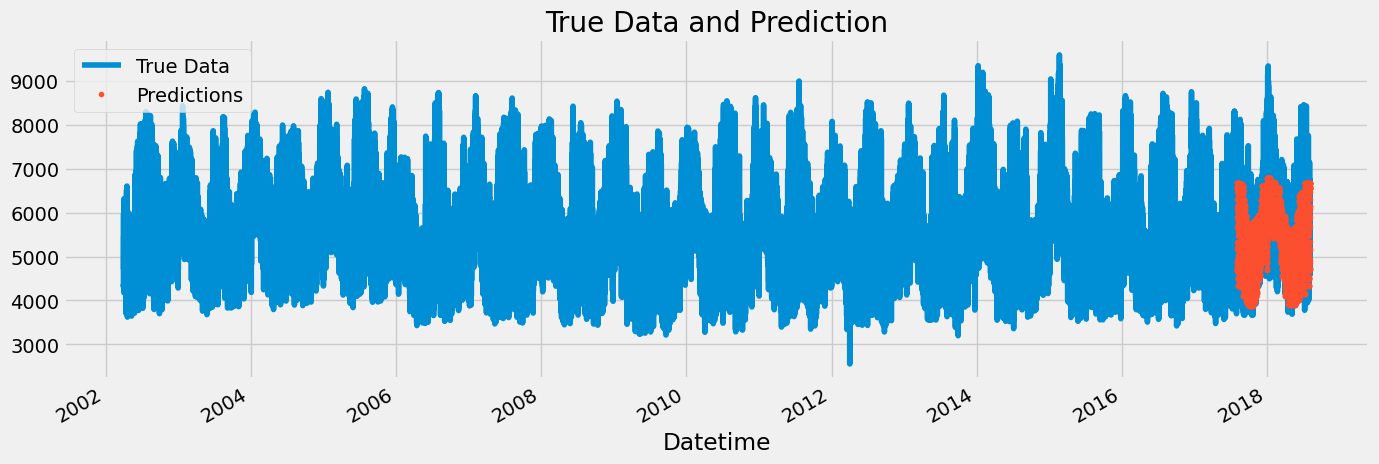

In [ ]:
test['prediction'] = reg.predict(X_test)
df_3 = df_2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_3[['PJMW_MW']].plot(figsize=(15, 5))
df_3['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('True Data and Prediction')
plt.show()

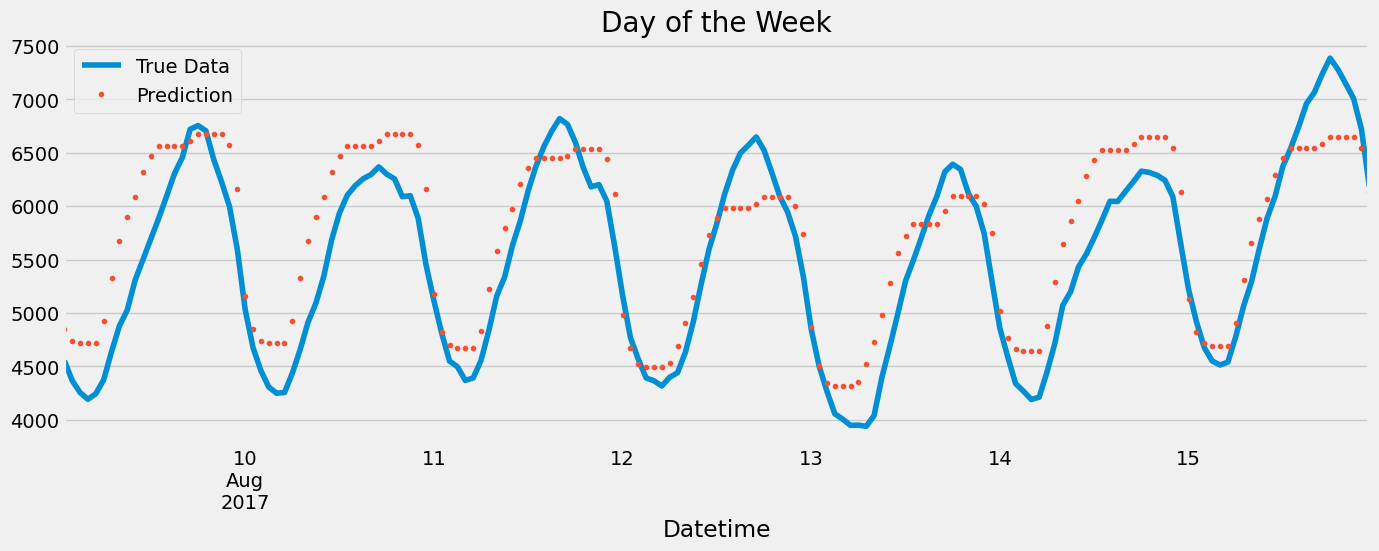

In [ ]:
# Plot the actual data
ax = df_3.loc[(df_3.index > '08-09-2017') & (df_3.index < '08-16-2017')]['PJMW_MW'] \
    .plot(figsize=(15, 5), title='Day of the Week')

# Plot the predictions
df_3.loc[(df_3.index > '08-09-2017') & (df_3.index < '08-16-2017')]['prediction'] \
    .plot(style='.')

plt.legend(['True Data', 'Prediction'])

plt.show()


# Evaluation metrics for test set

In [ ]:

# Calculate RMSE
score = np.sqrt(mean_squared_error(test['PJMW_MW'], test['prediction']))

# Calculate MAE
mae = mean_absolute_error(test['PJMW_MW'], test['prediction'])

# Print RMSE score on the test set
print(f'RMSE Score on Test set: {score:0.2f}')

# Print MAE score on the test set
print(f'MAE Score on Test set: {mae:0.2f}')

RMSE Score on Test set: 685.72
MAE Score on Test set: 508.95


# Prediction error analysis

In [ ]:
#to find the top 50 errors
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
largest_errors = test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(50)
largest_errors

<ipython-input-74-121de3a7d460>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test[TARGET] - test['prediction'])
<ipython-input-74-121de3a7d460>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


date
2018-01-06    2463.867126
2018-01-05    2333.195536
2017-12-31    2300.240479
2017-12-28    2119.494100
2018-01-07    2094.263387
2017-12-29    1880.487447
2017-12-30    1743.704285
2018-01-03    1653.286702
2018-01-04    1652.786702
2018-01-02    1621.120036
2017-12-27    1474.910767
2018-01-15    1470.647563
2018-01-17    1402.978882
2018-01-14    1356.763387
2018-01-01    1334.163717
2017-12-13    1279.360250
2018-01-18    1258.853882
2018-02-21    1222.126607
2018-07-01    1221.926290
2018-01-12    1217.596130
2018-07-03    1141.943644
2018-07-02    1128.381816
2017-12-15    1115.561930
2018-06-18    1102.923482
2017-11-11    1071.203959
2018-04-09    1055.222819
2018-03-14    1055.083944
2018-02-03    1021.483622
2018-02-20    1019.376607
2017-12-26     988.875122
2018-02-15     982.918762
2018-01-08     982.247050
2018-03-21     972.779561
2018-04-17     970.995565
2018-06-30     960.923991
2018-03-17     946.752482
2018-02-16     917.057922
2018-06-19     908.860311
2018-01

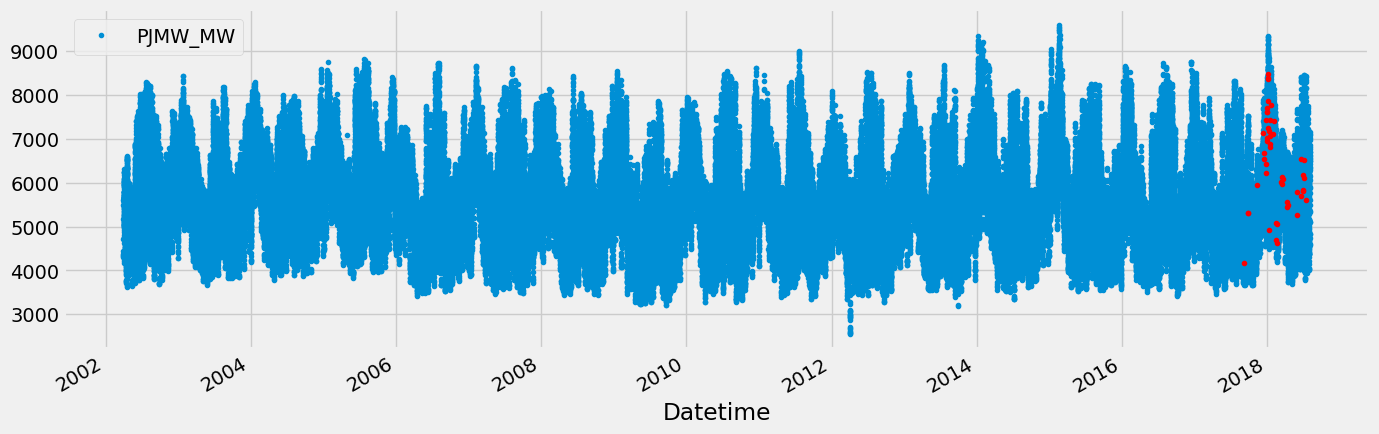

In [ ]:
#plotting the top 50 errors
plot_largest_errors = df.loc[df.index.isin(largest_errors.index)]
ax = df[['PJMW_MW']].plot(style='.', figsize=(15, 5))
plot_largest_errors['PJMW_MW'].plot(style='.', color='red')
plt.show()

# Future Prediction

In [ ]:
df_4 = create_features(df)


In [ ]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143205 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJMW_MW     143205 non-null  float64
 1   hour        143205 non-null  int64  
 2   dayofweek   143205 non-null  int64  
 3   quarter     143205 non-null  int64  
 4   month       143205 non-null  int64  
 5   year        143205 non-null  int64  
 6   dayofyear   143205 non-null  int64  
 7   dayofmonth  143205 non-null  int64  
 8   weekofyear  143205 non-null  UInt32 
dtypes: UInt32(1), float64(1), int64(7)
memory usage: 10.5 MB


In [ ]:
df_4['weekofyear'] = df_4['weekofyear'].astype(int)

In [ ]:
# Retrain the model on full data

FEATURES = ['hour', 'dayofweek','weekofyear', 'month','year']
TARGET = 'PJMW_MW'

X_all = df_4[FEATURES]
y_all = df_4[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.03)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[18:15:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5519.03913
[100]	validation_0-rmse:661.60696
[200]	validation_0-rmse:546.21573
[300]	validation_0-rmse:520.98246
[400]	validation_0-rmse:505.59898
[499]	validation_0-rmse:496.72801


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_4['isFuture'] = False
df_and_future = pd.concat([df_4, future_df])
df_and_future = create_features(df_and_future)

future_features = df_and_future.query('isFuture').copy()

In [ ]:
future_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8713 entries, 2018-08-03 00:00:00 to 2019-08-01 00:00:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PJMW_MW     0 non-null      float64
 1   hour        8713 non-null   int64  
 2   dayofweek   8713 non-null   int64  
 3   quarter     8713 non-null   int64  
 4   month       8713 non-null   int64  
 5   year        8713 non-null   int64  
 6   dayofyear   8713 non-null   int64  
 7   dayofmonth  8713 non-null   int64  
 8   weekofyear  8713 non-null   UInt32 
 9   isFuture    8713 non-null   bool   
dtypes: UInt32(1), bool(1), float64(1), int64(7)
memory usage: 663.7 KB


In [ ]:
future_features['weekofyear'] = future_features['weekofyear'].astype(int)

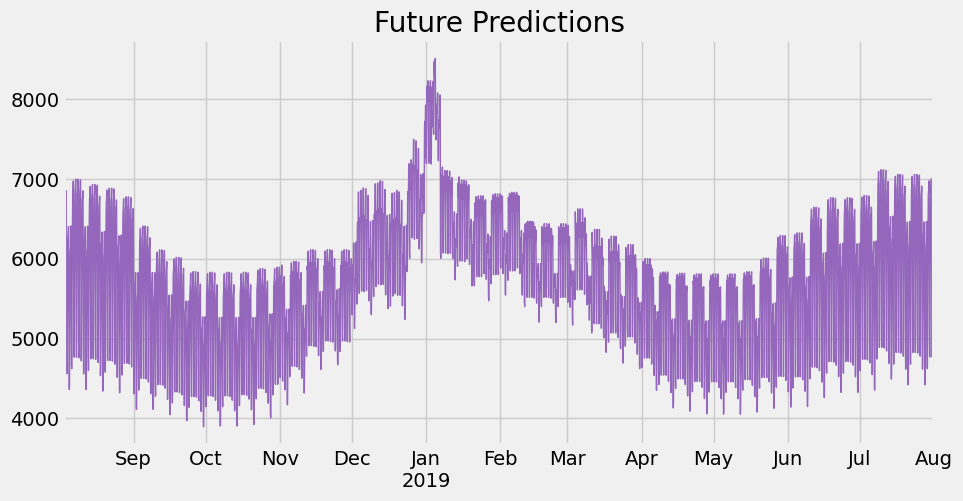

In [ ]:
# Add predictions to dataframe and plot
future_features['pred'] = reg.predict(future_features[FEATURES])

future_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()